# Decision Trees 


#### Setting up IPython Notebook
The code below simply sets up the jupyter notebook and displays graphs inline (e.g. as HTML)

In [18]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import numpy.linalg as la
np.set_printoptions(precision=3)
def pp_float_list(ps):#pretty print functionality
    return ["%2.3f" % p for p in ps]

# Long-term Goal: Implement the ID3-Algorithm

Experiments are conducted on the [UCI CAR Dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/car/).

We will cover
  
  * Data Setup
  * Impurity functions and impurity reduction
  * ID3 Algorithm for learning a decision tree
  * Classifying unseen examples
  * Evaluation using cross validation

## 1. Data Setup

### 1.1 Download and import the data

In [19]:
#shell scripts for downloading the data and placing it in a corresponding directory
!mkdir CAR 
!curl -o CAR/data "http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
!curl -o CAR/description "http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.names"
#download the description and display it here.
!cat CAR/description

Ein Unterverzeichnis oder eine Datei mit dem Namen "CAR" existiert bereits.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 30 51867   30 15642    0     0  31179      0  0:00:01 --:--:--  0:00:01 31284
100 51867  100 51867    0     0  78243      0 --:--:-- --:--:-- --:--:-- 78348
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  3097  100  3097    0     0   9238      0 --:--:-- --:--:-- --:--:--  9300
Der Befehl "cat" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


### 1.2 A bit of ugly preprocessing (ignore that part)

In [20]:
# csv-file has no header, so we define it manually
col_names = ['price_buy', 'price_main', 'n_doors', 'n_persons', 'lug_boot', 'safety', 'recommendation']
df = pd.read_csv("./CAR/data", header=None, names=col_names)

# All attributes are categorical - a mix of strings and integers.
# We simply map the categorical values of each attribute to a set of distinct integers
ai2an_map = col_names
ai2aiv2aivn_map = []
enc_cols = []
for col in df.columns:
    df[col] = df[col].astype('category')
    a = np.array(df[col].cat.codes.values).reshape((-1,1))
    enc_cols.append(a)
    ai2aiv2aivn_map.append(list(df[col].cat.categories.values))
    
# Get the data as numpy 2d-matrix (n_samples, n_features)
feature_names = ai2an_map
feature_value_names = ai2aiv2aivn_map[:6]
class_label_names = ai2aiv2aivn_map[6]

dataset = np.hstack(enc_cols)
X, y = dataset[:,:6], dataset[:,6]
print(X.shape, y.shape)

(1728, 6) (1728,)


### 1.3 The data

The data matrix ```X``` contains the preprocessed dataset. Each column corresponds to a feature. The feature names are given in ```feature_names```. The meaning of the feature values are given in ```feature_value_names```. 

The array ```y``` contains the class of each car. The meaning of each class is given in ```class_label_names```.

In [21]:
X, y

(array([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        ...,
        [1, 1, 3, 2, 0, 1],
        [1, 1, 3, 2, 0, 2],
        [1, 1, 3, 2, 0, 0]], dtype=int8),
 array([2, 2, 2, ..., 2, 1, 3], dtype=int8))

In [22]:
feature_names, feature_value_names, class_label_names

(['price_buy',
  'price_main',
  'n_doors',
  'n_persons',
  'lug_boot',
  'safety',
  'recommendation'],
 [['high', 'low', 'med', 'vhigh'],
  ['high', 'low', 'med', 'vhigh'],
  ['2', '3', '4', '5more'],
  ['2', '4', 'more'],
  ['big', 'med', 'small'],
  ['high', 'low', 'med']],
 ['acc', 'good', 'unacc', 'vgood'])

## 2. Impurity functions and impurity reduction
In the following, we will implement the impurity function(s) $\iota(D)$ and impurity reduction function $\Delta\iota(D,\{D_1\ldots D_s\})$.

$$
\iota(D) = \iota\left(\frac{|\{(x,c(x))\in D : c(x) = c_1\}|}{|D|},...,\frac{|\{(x,c(x))\in D : c(x) = c_k\}|}{|D|}\right)
$$

$$
\Delta\iota(D,\{D_1\ldots D_s\}) = \iota(D) - \sum_{j=1}^{s}\frac{|D_j|}{|D|}\cdot\iota(D_j)
$$


### 2.1 Impurity functions

In [23]:
def _entropy(p):
    """
    p: class frequencies as numpy array with np.sum(p)=1
    returns: impurity according to entropy criterion
    """
    idx = np.where(p == 0.) #consider 0*log(0) as 0
    p[idx] = 1.
  
    r = p * np.log2(p)
    
    return -np.sum(r)

def _gini(p):
    """
    p: class frequencies as numpy array with np.sum(p)=1
    returns: impurity according to gini criterion
    """
    return 1. - np.sum(p**2)

def _misclass(p):
    """
    p: class frequencies as numpy array with np.sum(p)=1
    returns: impurity according to misclassification rate
    """
    return 1-np.max(p)

In [24]:
_entropy(np.array([0.5, 0.5]))

1.0

Lets visualise the functions for the 2D case

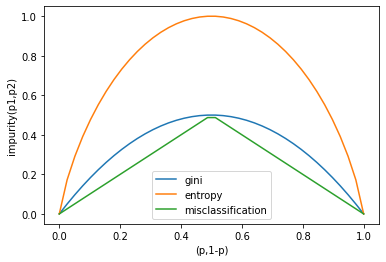

In [25]:
#lets plot the functions for the 2D case 
p1=np.linspace(0,1,40)
imp_gini=[_gini(np.array([p,1-p])) for p in p1]
imp_ent=[_entropy(np.array([p,1-p])) for p in p1]
imp_mc=[_misclass(np.array([p,1-p])) for p in p1]
plt.plot (p1,imp_gini,label="gini")
plt.plot (p1,imp_ent,label="entropy")
plt.plot (p1,imp_mc,label="misclassification")
plt.xlabel("(p,1-p)")
plt.ylabel("impurity(p1,p2)")
plt.legend()
plt.show()

### 2.2 Impurity reduction

In [26]:
def impurity_reduction(X, a_i, y, impurity, verbose=0):
    """
    Summary: This function evaluates the impurity reduction achieved by the 
    attribute `a_i` when the attribute were used for partitioning the dataset `X`.
    
    X: data matrix n rows, d columns
    a_i: column index of the attribute to evaluate the impurity reduction for
    y: class label vector with n rows and 1 column
    impurity: impurity function of the form impurity(p_1....p_k) with k=|X[a].unique|
    
    returns: impurity reduction
    """
    
    N, d = float(X.shape[0]), float(X.shape[1])

    y_v = np.unique(y)
    
    # Compute relative frequency of each class in X
    p = (1. / N) * np.array([np.sum(y==c) for c in y_v])
    # ..and corresponding impurity l(D)
    H_p = impurity(p)
    
    if verbose: print (f"\t Impurity {H_p:.5f}: Class Frequencies {pp_float_list(p)}")
    
    # a_v is an array of unique values in column a_i
    a_v = np.unique(X[:, a_i])
    
    """
    Create and evaluate splitting of X induced by attribute a_i
    We assume nominal features and perform m-ary splitting.
    
    We partition the dataset X into as many subsets as there are different values
    in attribute a_i. Each subset contains the exactly those data points that have 
    the value `a_vv` in attribute `a_i`. The following steps are required:
    - Once we have determined which data points belong to a subset (`mask_a`), 
      we can look up their corresponding class labels in the vector of 
      class labels `y`.
    - Then we count how many times each class label appears in the subset and
      calculate the relative frequencies `pa`.
    - Now we can calculate the impurity of the subset `H_pa_vv` based on the 
      relative frequencies `pa` of the classes that are present in the subset.
    - We add the impurity of the subset `H_pa_vv` to a list `H_pa`.
    - ...and repeat the process until we have evaluated all subsets

    """
    
    H_pa = []
    for a_vv in a_v:
        mask_a = X[:, a_i] == a_vv
        N_a = float(mask_a.sum())
                     
        # Compute relative frequency of each class in X[mask_a]
        pa = (1. / N_a) * np.array([np.sum(y[mask_a] == c) for c in y_v])
        H_pa_vv = (N_a / N) * impurity(pa)
        H_pa.append(H_pa_vv)
        if verbose: print (f"\t\t Impurity {H_pa[-1]:.5f} for value {a_vv} of attribute {a_i}: Class Frequencies {pp_float_list(pa)}")
    
    """
    The impurity reduction (aka "information gain" if we use entropy as a measure),
    is given by the difference of the impurity of the whole dataset `H_p` and the 
    weighted sum of the impurities of the subsets `np.sum(H_pa)`.
    """
    IR = H_p - np.sum(H_pa)
    if verbose:  print (f"\t\t Estimated reduction {IR:.5f}")
    return IR

# 3. ID3 Algorithm

Given the different impurity reduction functions, the ID3 algorithm is straight-forward. We build the tree recursively top-down. In each recursion step, we search for the attribute with maximum impurity reduction and create a new node in the tree.

### 3.1 Splitting

Splitting is done by finding the attribute that produces the largest impurity reduction.

Therefore, we define a function `get_split_attribute`. 

The function should call `impurity_reduction` that we have defined above.

The function should return an attribute (column index of the attribute in X) and the impurity reduction achieved by that attribute.

In [27]:
def get_split_attribute(X, y, attributes, impurity, verbose=0):
    """
    X: data matrix n rows, d columns
    y: vector with n rows, 1 column containing the class labels
    attributes: A dictionary. The key corresponds to an attribute's column index in X and the value is a list of values the attribute can take (its domain).
    impurity: impurity function of the form impurity(p_1....p_k) with k=|y.unique|
    returns: (1) column idx of attribute with maximum impurity reduction and (2) impurity reduction
    """
    
    N, d = X.shape
    IR = {}
    
    for a_i in attributes.keys():
        IR[a_i] = impurity_reduction(X, a_i, y, impurity, verbose)
        
    if verbose: print("Impurity reduction for class attribute (ordered by attributes)",(pp_float_list(IR)))
    
    b_a_i = max(IR, key=IR.get)
    
    return b_a_i, IR[b_a_i]

In [28]:
get_split_attribute(X, y, {k: None for k in range(X.shape[1])}, _gini, verbose=0)

(5, 0.07679411544067233)

### 3.2 Finding the most common class

For labeling nodes in the tree, we also need a function to quickly calculate the most common class label in a vector $y$ of class labels.

Let's define a function `most_common_class`, that takes a vector `y` of class labels and returns the most frequent label in `y`.

As a side quest: It's helpful later on, if the function also returns a boolean (`true`/`false`) to indicate whether all labels in `y` are the same (pure).

In [29]:
def most_common_class(y):
    """
    :param y: the vector of class labels, i.e. the target
    returns: (1) the most frequent class label in 'y' and (2) a boolean flag indicating whether y is pure
    """
    y_v, y_c = np.unique(y, return_counts=True)
    label = y_v[np.argmax(y_c)]
    fIsPure = len(y_v) == 1
    return label, fIsPure

### 3.3 Decision Nodes and the Decision Tree classifier

We need to get used to classes, before we can implement the algorithm.

A decision node should store the attribute this node splits on, a list of successor nodes (children) and the label assigned to that node.

In addition, each decision node gets an ID assigned, so we can identify nodes later on.

In [30]:
class DecisionNode(object):
    NODEID = 0

    def __init__(self, attr: int = -1, children : dict = None, label : int = None):
        """
        The column index of the split attribute in 'X'
        """
        self.attr = attr 
        
        """
        A dictionary of successor nodes.
        The dictionary key is a value of the split attribute and the corresponding object is the DecisionNode created for that branch
        Example: Attribute 'temperature' has values ['hot', 'medium', 'cold'].
                 Suppose the column index of 'temperature' in X is: 3. This value is stored in 'attr'.
                 The 'children' dictionary contains: 
                    {
                       'hot': DecisionNode(...), 
                       'medium': DecisionNode(...), 
                       'cold', DecisionNode(...)
                    }
        """
        self.children = children
        
        """
        The label assigned to that DecisionNode. A value from 'y'.
        """
        self.label = label
        
        """
        Some identifier for that DecisionNode. First node has value 0. Then 1, 2, 3....
        """
        self.id = DecisionNode.NODEID
        DecisionNode.NODEID += 1

#### Decision Tree class

The skeleton of our decision tree class should offer the following methods:
- `__init__(criterion, max_depth)`: When creating an instance of the decision tree, we need to pass the impurity function and initialize a `root` node
- `fit(X, y)`: Creates the decision tree on data points $X$ with labels $y$. The tree is constructed by recursively splitting on the **best** attribute. In each recursive call, we need to
    - check whether a the current node is pure (exit condition)
    - check whether the currently remaining attribute list is empty (exit condition)
    - check whether the current depth (d - remaining-attributes) exceeds max-depth (exit condition)
    - find the best attribute for splitting (i.e. `get_split_attribute(...)`)
    - call the function recursively for each data subset corresponding to each split and create a decision node.
- `predict(X)`: Starting from the root, follow the node-children relationships until we hit a node without children (leaf node). Then return the label of that node.
- `getDepth()`: Return the maximum depth of the tree: i.e. the maximum number of nodes from the root node to some leaf node 
- `printTree()`: A visualization of our tree.

Since tree traversal is a recursive procedure, I suggest you define your own "inner" function in each of the functions mentioned above.

See the following skeleton below.

In [31]:
# A couple of mistakes I made during the exercise:
# - get_split_attribute must be adapted to work with changing sets of 'attributes'
#   -> dont create list with size len(attributes)
#   -> instead create a dictionary IR = {} with attribute indices and IRs, 
#        then return the key with maximal IR
# - We need to create a copy of the 'attributes' dictionary at each node, 
#   otherwise all decision nodes work on a reference to the same 'attributes' object
# - getDepth must return 1 + max() over !node.children.values()!

class DecisionTreeID3(object):
    def __init__(self, criterion=_entropy, max_depth=10):
        self.root = None
        self.criterion = criterion
        self.max_depth = max_depth
        self.n_nodes = 0
    
    def fit(self, X, y, verbose=True):
        
        def _fit(X, y, attributes):
            
            N, d = X.shape
            
            depth = d - len(attributes)
            
            # isPure ?
            label, isPure = most_common_class(y)
            if isPure:
                return DecisionNode(label=label)
            
            # no more attributes to split on
            if len(attributes) == 0:
                return DecisionNode(label=label)
            
            # max depth exceeded
            if depth >= self.max_depth:
                return DecisionNode(label=label)
            
            # find "best" split attribute among the ones available (i.e. 'attributes')
            a_i, a_ir = get_split_attribute(X, y, attributes, self.criterion)
           
            childAttributes = attributes.copy()
            attribute_values = childAttributes.pop(a_i) # ['hot', 'medium', ..]
            
            children = {}
            for attribute_value in attribute_values:
                
                # X', y' = partition X and y according to the "best" split attribute
                split_mask = X[:,a_i] == attribute_value
                X_split, y_split = X[split_mask], y[split_mask]
                
                children[attribute_value] = _fit(X_split, y_split, childAttributes)
            
            return DecisionNode(attr=a_i, children=children, label=label)
            
        attributes = {a_i: np.unique(X[:, a_i]) for a_i in range(X.shape[1])}

        self.n_nodes = DecisionNode.NODEID
        
        self.root = _fit(X, y, attributes)
        
        self.n_nodes = DecisionNode.NODEID - self.n_nodes
        
        return self
    
    def predict(self, X):
        
        def _predict(x, node):
            if not node.children:
                return node.label
            else:
                value = x[node.attr]
                childNode = node.children[value]
                return _predict(x, childNode)

        return [_predict(x, self.root) for x in X]
    
    def getDepth(self):
        
        def _depth(node):
            if not node.children:
                return 0
            else:
                return 1 + max([_depth(child) for child in node.children.values()])
        
        return _depth(self.root)
    
    def printTree(self, 
                  attribute_name_map=ai2an_map, 
                  attribute_value_map=ai2aiv2aivn_map
                 ):
        
        def _print(node, test="", level=0):
            
            prefix = ""
            prefix += " " * level
            prefix += " |--(%s):" % test
                
            if not node.children:
                print(f"{prefix} LEAF label: {node.label}")
            else:
                name_attr = attribute_name_map[node.attr]
                print("%s test attribute '%s'" % (prefix, attribute_name_map[node.attr]))
                for av, child in node.children.items():
                    n_children = len(child.children) if child.children else 0
                    name_attr_v = attribute_value_map[node.attr][av]
                    _print(child, "id=%d n_children=%d %s=%s?" % (child.id, n_children, name_attr, name_attr_v), level+1)
        
        print(f"Tree [depth={self.getDepth()} n_nodes={self.n_nodes}]")
        _print(self.root)

### 3.4 Training of the Decision Tree and Evaluation on Training data

#### Helpers for evaluation

In [32]:
def confmat(y_true, y_pred):
    """
    row index: actual class
    col index: predicted class
    
    returns: confusion matrix C and list of class 'labels' 
            with C[i,j] being the number of data points from class labels[i] that
            have been classified as belonging to class labels[j]
    """
    
    labels = np.unique(y_true)
    n_classes = len(labels)
    C = np.zeros((n_classes, n_classes))
    
    for i in range(n_classes):
        for j in range(n_classes):
            C[i,j] = np.sum((y_true == labels[i]) & (y_pred == labels[j]))
    
    return C, labels

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

MaxDepth: 1
Fitted Tree [depth=1 n_nodes=4]
[[   0.    0.  384.    0.]
 [   0.    0.   69.    0.]
 [   0.    0. 1210.    0.]
 [   0.    0.   65.    0.]]
Accuracy: 0.70


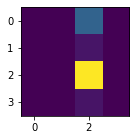

MaxDepth: 2
Fitted Tree [depth=2 n_nodes=10]
[[384.   0.   0.   0.]
 [ 69.   0.   0.   0.]
 [250.   0. 960.   0.]
 [ 65.   0.   0.   0.]]
Accuracy: 0.78


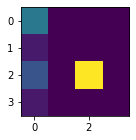

MaxDepth: 3
Fitted Tree [depth=3 n_nodes=26]
[[ 282.    0.   87.   15.]
 [  61.    0.    0.    8.]
 [  93.    0. 1113.    4.]
 [  44.    0.    0.   21.]]
Accuracy: 0.82


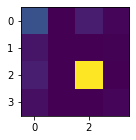

MaxDepth: 4
Fitted Tree [depth=4 n_nodes=88]
[[ 358.   12.    6.    8.]
 [  18.   39.    0.   12.]
 [  80.    3. 1122.    5.]
 [  12.   18.    0.   35.]]
Accuracy: 0.90


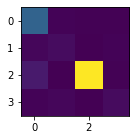

MaxDepth: 5
Fitted Tree [depth=5 n_nodes=222]
[[ 379.    3.    0.    2.]
 [   6.   60.    0.    3.]
 [  35.    3. 1172.    0.]
 [   4.    6.    0.   55.]]
Accuracy: 0.96


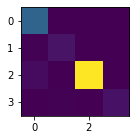

MaxDepth: 6
Fitted Tree [depth=6 n_nodes=408]
[[ 384.    0.    0.    0.]
 [   0.   69.    0.    0.]
 [   0.    0. 1210.    0.]
 [   0.    0.    0.   65.]]
Accuracy: 1.00


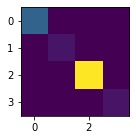

In [33]:
for depth in range(1, 7):
    
    print(f"MaxDepth: {depth}")
    tree = DecisionTreeID3(criterion=_entropy, max_depth=depth)
    tree.fit(X, y, verbose=False)
    print(f"Fitted Tree [depth={tree.getDepth()} n_nodes={tree.n_nodes}]")
    
    #tree.printTree()

    y_hat = tree.predict(X)

    confMat, _ = confmat(y, y_hat)
    acc = accuracy(y, y_hat)

    print(confMat)
    print(f"Accuracy: {acc:.2f}")
    
    plt.figure(figsize=(2,2))
    plt.imshow(confMat)
    plt.show()